In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [3]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

## Preparando Dados

In [4]:
enem = pd.read_csv('../src/enem_total_dum_pad.csv')

enem.set_index('NU_INSCRICAO', drop=True, inplace=True)

enem.head()

,IN_BRAILLE,IN_AMPLIADA_18,IN_AMPLIADA_24,IN_LEDOR,IN_ACESSO,IN_TRANSCRICAO,IN_LIBRAS,APPROVED_ADM,APPROVED_MED,TP_SEXO_M,...,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q005,NU_NOTA_MEDIA
NU_INSCRICAO,,,,,,,,,,,,,,,,,,,,,
190003903183,0,0,0,0,0,0,0,0,0,0,...,-1.334171,-0.687464,-1.705344,-1.669531,-1.399352,-1.590848,-1.625610,-1.941498,0.833696,-1.095479
190005124618,0,0,0,0,0,0,0,0,0,0,...,0.284978,-1.080209,-0.197405,-0.470414,0.357392,-0.217934,0.531056,0.134470,0.119915,-0.399954
190001447215,0,0,0,0,0,0,0,0,0,0,...,-0.033489,0.030073,-0.145969,0.328998,-0.345306,-0.082924,-0.043306,-0.044617,-0.593865,0.005194
190003825026,0,0,0,0,0,0,0,0,0,1,...,-1.877900,-0.326874,-1.202697,-0.470414,-1.399352,-1.133210,-1.625610,-1.143049,0.119915,-0.999289
190001995539,0,0,0,0,0,0,0,0,0,0,...,0.431443,0.733079,1.813181,1.528115,1.411439,2.070257,1.825056,1.891058,0.833696,0.421357


In [5]:
enem.shape

(10000, 2382)

In [6]:
def plot_roc_curve(y_true, y_score, figsize=(10,6)):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure(figsize = figsize)
    auc_value = roc_auc_score(y_true, y_score)
    plt.plot(fpr, tpr, color = 'orange', label = 'ROC CURVE (area = %0.2f)' % auc_value)
    plt.plot([0,1], [0,1], color = 'darkblue', linestyle = '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic ROC Curve')
    plt.legend()
    plt.show()

In [7]:
X = enem.drop(['APPROVED_ADM', 'APPROVED_MED'], axis=1)
y = enem['APPROVED_ADM']

## Primeiro Modelo Logístico

In [8]:
model = LogisticRegression()

In [9]:
y.value_counts()

0    8471
1    1529
Name: APPROVED_ADM, dtype: int64

In [10]:
model_fit = model.fit(X, y)

C:\Users\DESKTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
yhat = model.predict_proba(X)

yhat

array([[1.00000000e+00, 1.99285423e-19],
       [1.00000000e+00, 1.17501909e-13],
       [1.00000000e+00, 4.19247943e-10],
       ...,
       [1.00000000e+00, 1.66539434e-12],
       [1.00000000e+00, 9.39486845e-15],
       [1.00000000e+00, 8.45050340e-18]])

In [12]:
yhat = yhat[:, 1]

In [13]:
yhat

array([1.99285423e-19, 1.17501909e-13, 4.19247943e-10, ...,
       1.66539434e-12, 9.39486845e-15, 8.45050340e-18])

In [14]:
matrix = confusion_matrix(y, model.predict(X))

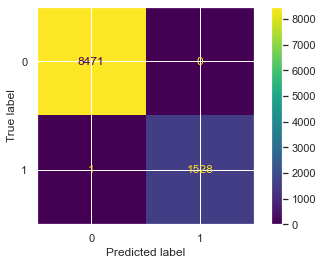

In [16]:
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()

In [ ]:
print(classification_report(y, model.predict(X)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8471
           1       1.00      1.00      1.00      1529

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



In [ ]:
print('AUC: %0.5f' % roc_auc_score(y, yhat))

AUC: 1.00000


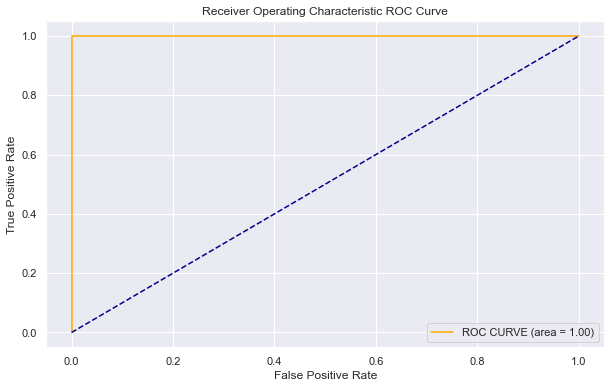

In [ ]:
plot_roc_curve(y, yhat)

## Segundo Modelo Logístico com Validação Cruzada

In [ ]:
test_size = 0.20
np.random.seed(7)
scoring = 'accuracy'
num_folds = 10
solver = 'newton-cg'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)

In [ ]:
model = LogisticRegression(solver = solver)

In [ ]:
kfold = KFold(n_splits = num_folds)

In [ ]:
cv_result = cross_val_score(model, X_train, y_train, cv = kfold, scoring = scoring)

In [ ]:
cv_result

array([0.9975 , 0.995  , 0.99625, 0.99625, 0.99625, 0.9975 , 0.99625,
       0.99625, 0.9925 , 0.99   ])

In [ ]:
print('%s: %0.5f(%0.4f)' % ('Regressão Logística', cv_result.mean(), cv_result.std()))

Regressão Logística: 0.99538(0.0022)


## Ajuste dos Hiperparâmetros do Modelo Logístico

## Comparação entre Modelos de Classificação

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler

In [ ]:
models = []

In [ ]:
models.append(('LR', LogisticRegression(solver='newton-cg')))

In [ ]:
models.append(('KNN', KNeighborsClassifier()))

In [ ]:
models.append(('CART', DecisionTreeClassifier()))

In [ ]:
models.append(('NB', GaussianNB()))

In [ ]:
models.append(('SVM', SVC()))

In [ ]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.995375 (0.002240)
KNN: 0.971625 (0.006350)
CART: 1.000000 (0.000000)
NB: 0.367750 (0.014511)
SVM: 0.991750 (0.003269)


## Método da Máxima Verossimilhança

In [ ]:
model.classes_

AttributeError: 'SVC' object has no attribute 'classes_'

In [ ]:
model.intercept_

array([-21.07417003])

In [ ]:
model.coef_

array([[ 0.00000000e+00, -2.10619664e-03,  0.00000000e+00, ...,
         2.20322086e-01,  1.36162989e-01,  5.22376168e+00]])

In [ ]:
log_likelihood_elements = y*np.log(yhat) + (1-y)*np.log(1-yhat)
log_likelihood_elements

NU_INSCRICAO
190003903183    0.000000e+00
190005124618   -1.174616e-13
190001447215   -4.192480e-10
190003825026    0.000000e+00
190001995539   -2.628550e-06
                    ...     
190005285745    0.000000e+00
190001247842   -3.713141e-11
190003996202   -1.665446e-12
190002228082   -9.436896e-15
190002234389    0.000000e+00
Name: APPROVED_ADM, Length: 10000, dtype: float64

In [ ]:
-np.sum(log_likelihood_elements)/len(y)
# 0.60671964791658428

log_loss(y, yhat) == -np.sum(log_likelihood_elements)/len(y)

NameError: name 'log_loss' is not defined

## Modelo Logistico com Stats Model

In [ ]:
import statsmodels.api as sm

In [ ]:
model = sm.Logit(y, X)

In [ ]:
corr = np.corrcoef(X.values, rowvar=False)
sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f', cbar=False, xticklabels=X.columns, yticklabels=X.columns)

C:\Users\DESKTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\DESKTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [ ]:
result = model.fit(method='newton')

C:\Users\DESKTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\DESKTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: inf
         Iterations: 35


LinAlgError: Singular matrix

In [ ]:
result.params

In [ ]:
result.summary()